In [1]:
from pathlib import Path

name = "librispeech-dev-clean"
in_dir = Path("data/dev-clean")
align_dir = Path("data/alignments/dev-clean")
feat_dir = Path("features")
audio_ext = ".flac"     

In [13]:
from encode import sample_files
from utils.features import DataSet

dataset = DataSet(
    name, in_dir, align_dir, feat_dir, audio_ext 
)

sample_size = 50
model_name = "hubert_base"
layer = 7
out_dir = Path(f"output/{model_name}/{sample_size}")

sampled_paths = sample_files(dataset, sample_size)
print(len(sampled_paths))

50


In [14]:
from encode import get_encodings

words = get_encodings(dataset, model_name, sampled_paths, layer, out_dir)

Getting units: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


In [15]:
out_dir = Path(f"output/{model_name}/{layer}/{sample_size}")

In [ ]:
from distance import encodings_from_words, dtw

encodings = encodings_from_words(words)
norm_dist_mat = dtw(encodings, out_dir)
print(norm_dist_mat[0:5, 0:5])

(14, 768)


Calculating Distances:  36%|███▌      | 435/1217 [01:18<02:00,  6.49it/s]

In [ ]:
from utils.features import display_words

true_words = display_words(words)

Sorted Word Counts


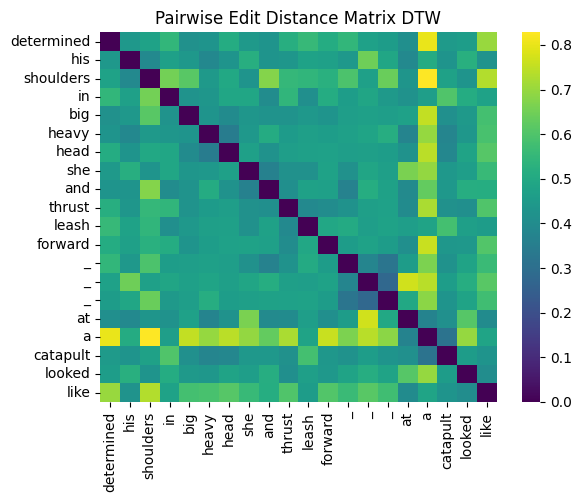

In [ ]:
from eval import pairwise_edit_dist_mat

# Visualise the distances
pairwise_edit_dist_mat(norm_dist_mat, "Pairwise Edit Distance Matrix DTW", true_words)

In [ ]:
from cluster import cluster, get_word_clusters

# Get the int_clusters for each of the matrices
clusters = cluster(norm_dist_mat, 0.2)

# Convert these to word clusters
word_clusters = get_word_clusters(clusters, words)

Getting Word Clusters: 100%|██████████| 20/20 [00:00<00:00, 537731.28it/s]


In [ ]:
from eval import ned

# Compute the ned for my dusted and hubert clusters - atm my NED is computed only using clusters with > 1 words
ned_dtw = ned(word_clusters, print_pure=False, print_inpure=True)
print(f"DUSTED NED: {ned_dtw}")

Calculating NED: 100%|██████████| 20/20 [00:00<00:00, 687590.82it/s]

DUSTED NED: 0


In [ ]:
from cluster import get_best_clusters

ned_dtw, duplicate_count, word_clusters = get_best_clusters(word_clusters, ned_dtw, max_iter=5)

Iteration 0: NED: 0.000000, Duplicates: 3


Calculating NED: 100%|██████████| 20/20 [00:00<00:00, 645277.54it/s]

Iteration 1: NED: 0.000000
Converged early due to no significant improvement in NED or duplicate count.
Best NED: 0.000000, Best Duplicates: 3


In [ ]:
from eval import words_from_word_units, clusters_purity
            
just_words_clusters = words_from_word_units(word_clusters)
inpurity, total = clusters_purity(just_words_clusters)
print(f"{total} Dusted Clusters with inpurity: {round(inpurity*100, 3)}%")

20 Dusted Clusters with inpurity: 10.0%


In [ ]:
from eval import calculate_duplicate_clusters

cluster_counts, duplicate_counts = calculate_duplicate_clusters(word_clusters, print_clusters=True)

Total duplicate clusters (considering word frequency): 3
Duplicate clusters and their counts:
{'_': 1}: 3 times


In [ ]:
from encode import sample_files
from utils.features import load_units_from_paths
from encode import get_units
from cluster import get_distance_to_centroids, get_cluster_centroids
import editdistance
import statistics

query_path = sample_files(dataset, sample_size=1)

# Query one of the ladys
# query_path = [Path("data/dev-clean/174/50561/174-50561-0013.flac")]

query_words = load_units_from_paths(dataset, "dusted", query_path, gamma=0.2)
if not query_words:
    query_ords = get_units(dataset, "dusted", query_path, gamma=0.2, save=True)
query_sentence = " ".join([w.true_word for w in query_words])

centroids = get_cluster_centroids(word_clusters)
query_words = get_distance_to_centroids([query_words], centroids)


predictions = []
query_distances = []
for word in query_words:
    prediction = centroids[word.cluster_id].true_word
    # print(" : ".join([word.true_word, prediction]))
    query_distances.append(editdistance.eval(word.true_word, prediction)/max(len(word.true_word), len(prediction)))
    predictions.append(prediction)

prediction_sentence = " ".join(predictions)
print(f"NED for query: {statistics.mean(query_distances)}")
print(query_sentence)
print(prediction_sentence)